# Visualization

---

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import* 
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import folium

In [3]:
spark = (
    SparkSession.builder.appName("Visualisation")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.driver.memory","8G")
    .config("spark.executor.memory","8G")
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

24/09/13 02:07:58 WARN Utils: Your hostname, Cocos-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.33.67 instead (on interface en0)
24/09/13 02:07:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/13 02:07:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Read datasets

In [3]:
# read datasets
merged_external_df = pd.read_csv('../data/curated/merged_external_geo.csv')

merchant_total_count_dollar = spark.read.parquet('../data/curated/merchant_total_count_dollar')
merchant_total_count_dollar_df = merchant_total_count_dollar.toPandas()

consumer_total_count_dollar = spark.read.parquet('../data/curated/consumer_total_count_dollar')
consumer_total_count_dollar_df = consumer_total_count_dollar.toPandas()

consumer_total_count_dollar_bySA2_geo = pd.read_csv('../data/curated/consumer_total_count_dollar_bySA2_geo.csv')

merchant = spark.read.parquet('../data/curated/merchant')
merchant_df = merchant.toPandas()

merchant_full = spark.read.parquet('../data/curated/merchant_full')
merchant_select_df = merchant_full.select('merchant_abn', 'transaction_revenue').toPandas()

consumer = spark.read.parquet('../data/curated/consumer')
consumer_pd = consumer.toPandas()

final_imputed_consumer = spark.read.parquet('../data/curated/final_imputed_consumer')
final_imputed_consumer_df = final_imputed_consumer.select('fraud_probability', 'gender', 'state').toPandas()

final_imputed_merchant = spark.read.parquet('../data/curated/final_imputed_merchant')
final_imputed_merchant_df = final_imputed_merchant.select('fraud_probability').toPandas()

### Convert data type

In [5]:
# check the data type
print('merged_external_df:')
print(merged_external_df.dtypes)

print('\nmerchant_total_count_dollar_df:')
print(merchant_total_count_dollar_df.dtypes)

print('\nconsumer_total_count_dollar_df:')
print(consumer_total_count_dollar_df.dtypes)

print('\nconsumer_total_count_dollar_bySA2_geo:')
print(consumer_total_count_dollar_bySA2_geo.dtypes)

merged_external_df:
SA2_name                          object
average_population               float64
Median_age_persons                 int64
Median_mortgage_repay_monthly      int64
Median_tot_prsnl_inc_weekly        int64
Median_rent_weekly                 int64
Median_tot_fam_inc_weekly          int64
Average_num_psns_per_bedroom     float64
Median_tot_hhd_inc_weekly          int64
Average_household_size           float64
geometry                          object
postcode                           int64
state                             object
unemployment_rate                float64
dtype: object

merchant_total_count_dollar_df:
merchant_abn            int64
transaction_count       int64
total_dollar_value    float64
dtype: object

consumer_total_count_dollar_df:
consumer_id                  int64
total_transaction_count      int64
total_dollar_value         float64
user_id                      int64
postcode                     int32
dtype: object

consumer_total_count_dollar_bySA

In [5]:
# convert the 'geometry' column from WKT strings to Shapely geometries
merged_external_df['geometry'] = merged_external_df['geometry'].apply(wkt.loads)
consumer_total_count_dollar_bySA2_geo['geometry'] = consumer_total_count_dollar_bySA2_geo['geometry'].apply(wkt.loads)

# create a GeoDataFrame
merged_external_gdf = gpd.GeoDataFrame(merged_external_df, geometry='geometry')
consumer_total_count_dollar_bySA2_gdf = gpd.GeoDataFrame(consumer_total_count_dollar_bySA2_geo, geometry='geometry')

# set the original CRS (assuming Web Mercator for example)
merged_external_gdf.set_crs(epsg=4326, inplace=True)
consumer_total_count_dollar_bySA2_gdf.set_crs(epsg=4326, inplace=True)

# confirm the datatype has been converted
print('merged_external_gdf:')
print(merged_external_gdf.dtypes)

print('\nconsumer_total_count_dollar_bySA2_gdf:')
print(consumer_total_count_dollar_bySA2_gdf.dtypes)

24/09/10 11:21:43 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


merged_external_gdf:
SA2_name                           object
average_population                float64
Median_age_persons                  int64
Median_mortgage_repay_monthly       int64
Median_tot_prsnl_inc_weekly         int64
Median_rent_weekly                  int64
Median_tot_fam_inc_weekly           int64
Average_num_psns_per_bedroom      float64
Median_tot_hhd_inc_weekly           int64
Average_household_size            float64
geometry                         geometry
postcode                            int64
state                              object
unemployment_rate                 float64
dtype: object

consumer_total_count_dollar_bySA2_gdf:
SA2_name                     object
total_transaction_count       int64
total_dollar_value          float64
postcode                      int64
state                        object
geometry                   geometry
dtype: object


### Display the datasets

In [6]:
merged_external_gdf.head()

,SA2_name,average_population,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,geometry,postcode,state,unemployment_rate
0,Braidwood,4349.0,51,1732,760,330,1886,0.8,1429,2.2,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4...",2580,NSW,3.5
1,Braidwood,4349.0,51,1732,760,330,1886,0.8,1429,2.2,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4...",2622,NSW,3.5
2,Karabar,8538.0,38,1950,975,350,2334,0.8,1989,2.6,"POLYGON ((149.21899 -35.36738, 149.218 -35.366...",2620,NSW,4.3
3,Queanbeyan,11382.5,37,1700,996,330,2233,0.9,1703,2.1,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3...",2620,ACT,4.2
4,Queanbeyan,11382.5,37,1700,996,330,2233,0.9,1703,2.1,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3...",2620,ACT,3.1


In [9]:
merchant_total_count_dollar_df.head()

,merchant_abn,transaction_count,total_dollar_value
0,83412691377,14288,4.985366e+05
1,38700038932,7132,9.546185e+06
2,35344855546,1522,1.347373e+05
3,15613631617,1785,5.430305e+05
4,19839532017,726,1.139820e+05


In [8]:
consumer_total_count_dollar_df.head()

,consumer_id,total_transaction_count,total_dollar_value,user_id,postcode
0,757778,587,83174.373466,492,2799
1,798840,564,80613.514533,623,5415
2,341890,564,84301.448091,771,6522
3,769055,566,84282.462204,821,1132
4,1435025,569,87017.066201,12050,4869


In [9]:
consumer_total_count_dollar_bySA2_gdf.head()

,SA2_name,total_transaction_count,total_dollar_value,postcode,state,geometry
0,ACT - South West,13006,2.002136e+06,2902,ACT,"POLYGON ((148.88381 -35.26411, 148.94988 -35.2..."
1,APY Lands,9080,1.400538e+06,872,NT,"POLYGON ((129.00186 -26.72252, 129.00186 -26.7..."
2,Abbotsford,3369,5.278622e+05,3067,VIC,"POLYGON ((144.99255 -37.80249, 144.99266 -37.8..."
3,Aberfoyle Park,3959,6.247266e+05,5159,SA,"POLYGON ((138.58963 -35.06584, 138.58993 -35.0..."
4,Acacia Gardens,4526,7.369201e+05,2763,NSW,"POLYGON ((150.91593 -33.72971, 150.91661 -33.7..."


In [8]:
merchant_df.head()

,merchant_abn,order_datetime,fraud_probability,name,category,revenue_level,take_rate
0,10023283211,None,NaN,felis limited,"furniture, home furnishings and equipment shop...",e,0.18
1,10142254217,None,NaN,arcu ac orci corporation,"cable, satellite, and other pay television and...",b,4.22
2,10165489824,None,NaN,nunc sed company,"jewelry, watch, clock, and silverware shops",b,4.40
3,10187291046,None,NaN,ultricies dignissim lacus foundation,"watch, clock, and jewelry repair shops",b,3.29
4,10192359162,None,NaN,enim condimentum pc,"music shops - musical instruments, pianos, and...",a,6.33


In [4]:
merchant_select_df.head()

,merchant_abn,transaction_revenue
0,63290521567,38.567297
1,63465140133,8.490884
2,21359184622,64.070348
3,75034515922,18.432455
4,96334476428,6.150231


# Consumer Related Distributions

### Total transaction count for each concumer distribution

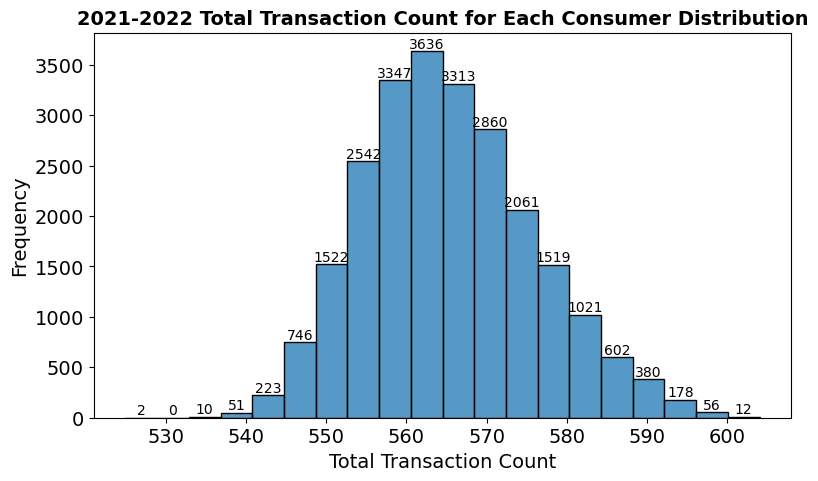

In [ ]:
consumer_total_count_dollar_data = consumer_total_count_dollar_df['total_transaction_count']

# create the plot
plt.figure(figsize=(9, 5))
ax = sns.histplot(consumer_total_count_dollar_data, bins=20, kde=False)

plt.title('2021-2022 Total Transaction Count for Each Consumer Distribution', weight='bold', fontsize=14)
plt.xlabel('Total Transaction Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/consumer_total_count_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Total transaction value for each concumer distribution

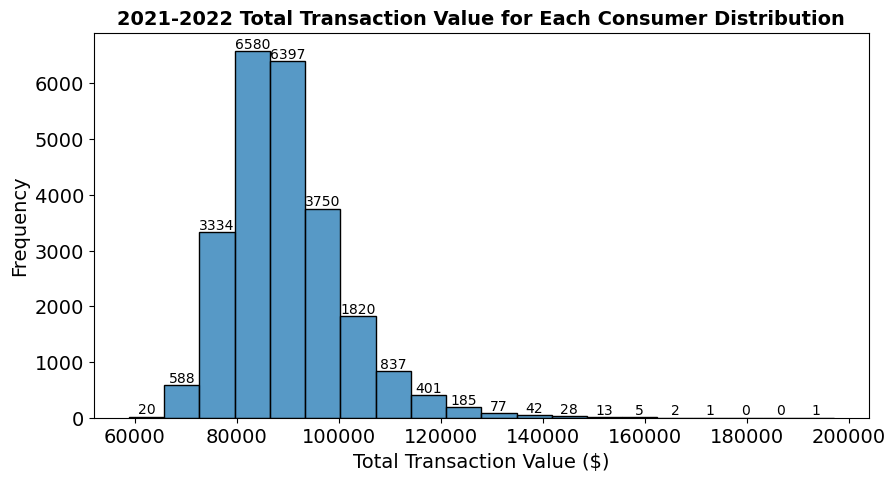

In [ ]:
consumer_total_count_dollar_data = consumer_total_count_dollar_df['total_dollar_value']

# create the plot
plt.figure(figsize=(10, 5))
ax = sns.histplot(consumer_total_count_dollar_data, bins=20, kde=False)

plt.title('2021-2022 Total Transaction Value for Each Consumer Distribution', weight='bold', fontsize=14)
plt.xlabel('Total Transaction Value ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/consumer_total_values_hist.png', dpi=300, bbox_inches='tight')
plt.show()

## Distribution of `ordered_datetime` BEFORE Imputating Nulls

In [18]:
# disgard 'ordered_date' missing values in the consumer table
consumer_table_not_null_order = consumer_pd[consumer_pd['order_datetime'].notnull()]
consumer_table_not_null_order['order_datetime'] = pd.to_datetime(consumer_table_not_null_order['order_datetime'])

/var/folders/rc/ddmw432j4cj3k9y_h6wn3npw0000gn/T/ipykernel_57711/1522922090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_table_not_null_order['order_datetime'] = pd.to_datetime(consumer_table_not_null_order['order_datetime'])


### Consumer Table: Order Datetime Distribution by Year and Month

/var/folders/rc/ddmw432j4cj3k9y_h6wn3npw0000gn/T/ipykernel_57711/3537706490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_table_not_null_order['order_year_month'] = consumer_table_not_null_order['order_datetime'].dt.to_period('M')


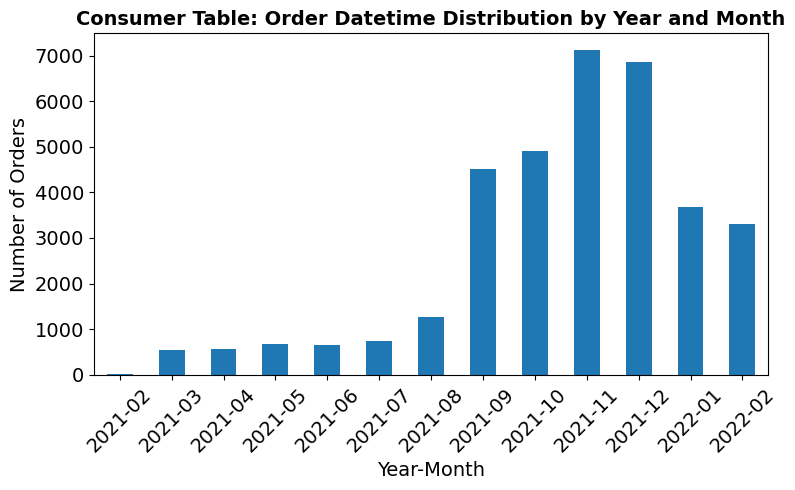

In [21]:
# number of orders per month
consumer_table_not_null_order['order_year_month'] = consumer_table_not_null_order['order_datetime'].dt.to_period('M')
order_counts_by_month = consumer_table_not_null_order['order_year_month'].value_counts().sort_index()

# plot
plt.figure(figsize=(8, 5))
order_counts_by_month.plot(kind='bar')
plt.title('Consumer Table: Order Datetime Distribution by Year and Month',
           weight='bold', fontsize=14)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# save and display the plot
plt.savefig('../plots/consumer_orderdate_by_year_month.png', dpi=300, bbox_inches='tight')
plt.show()

### Consumer Table: Order Datetime Distribution by Day

/var/folders/rc/ddmw432j4cj3k9y_h6wn3npw0000gn/T/ipykernel_57711/1676757110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_table_not_null_order['order_day'] = consumer_table_not_null_order['order_datetime'].dt.date


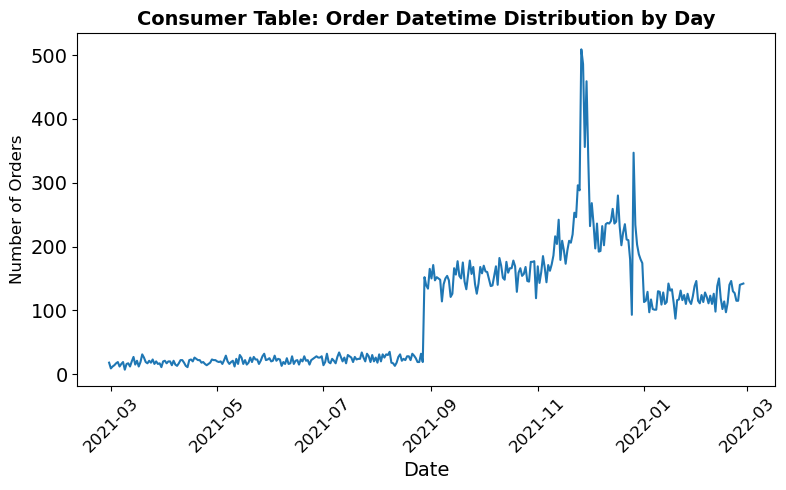

In [20]:
# number of orders per day
consumer_table_not_null_order['order_day'] = consumer_table_not_null_order['order_datetime'].dt.date
order_counts_by_day = consumer_table_not_null_order['order_day'].value_counts().sort_index()

# plot
plt.figure(figsize=(8, 5))
plt.plot(order_counts_by_day.index, order_counts_by_day.values)
plt.title('Consumer Table: Order Datetime Distribution by Day', weight='bold', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=14)
plt.tight_layout()

# save and display the plot
plt.savefig('../plots/consumer_orderdate_by_day.png', dpi=300, bbox_inches='tight')
plt.show()

## Consumer Fraud Probability Distributions

### BEFORE Fill in Missing Values

#### Average consumer fraud probability (by state)

  state  fraud_probability
5   TAS          15.384440
2    NT          15.308709
3   QLD          15.277821
6   VIC          15.162125
4    SA          15.144591
1   NSW          15.133762
7    WA          14.831026
0   ACT          14.408423


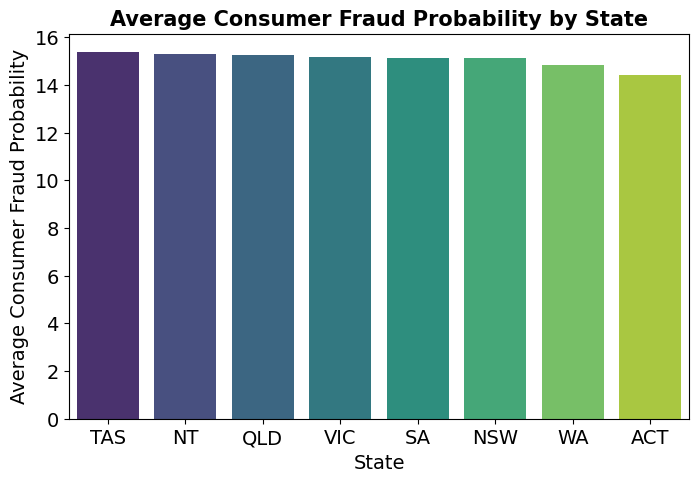

In [58]:
# group by 'state' and calculate the average 'fraud_probability'
avg_fraud_by_state = consumer_pd.groupby('state')['fraud_probability'].mean().reset_index()

# sort the result by fraud probability 
avg_fraud_by_state = avg_fraud_by_state.sort_values(by='fraud_probability', ascending=False)
print(avg_fraud_by_state)

# plot
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_fraud_by_state, x='state', y='fraud_probability', palette='viridis')
plt.title('Average Consumer Fraud Probability by State', weight='bold', fontsize=15)
plt.xlabel('State', fontsize=14)
plt.ylabel('Average Consumer Fraud Probability', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.savefig('../plots/avg_consumer_fraud_prob_by_state_before.png', 
            dpi=300, bbox_inches='tight')
plt.show()

#### Distribution of consumer fraud probability (by gender)

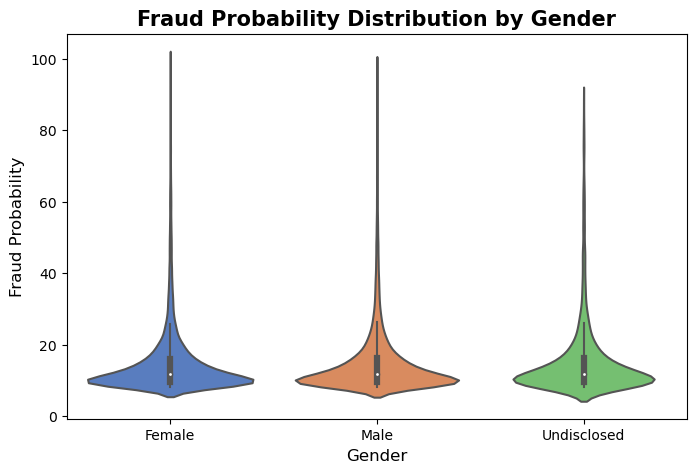

In [8]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=consumer_pd, x='gender', y='fraud_probability', palette='muted')
plt.title('Fraud Probability Distribution by Gender', fontsize=15, weight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Fraud Probability', fontsize=12)

# save and display the plot
plt.savefig('../plots/violin_avg_fraud_prob_by_gender_before.png', dpi=300, bbox_inches='tight')
plt.show()

#### Heatmap of Average Consumer Fraud probability (state and gender)

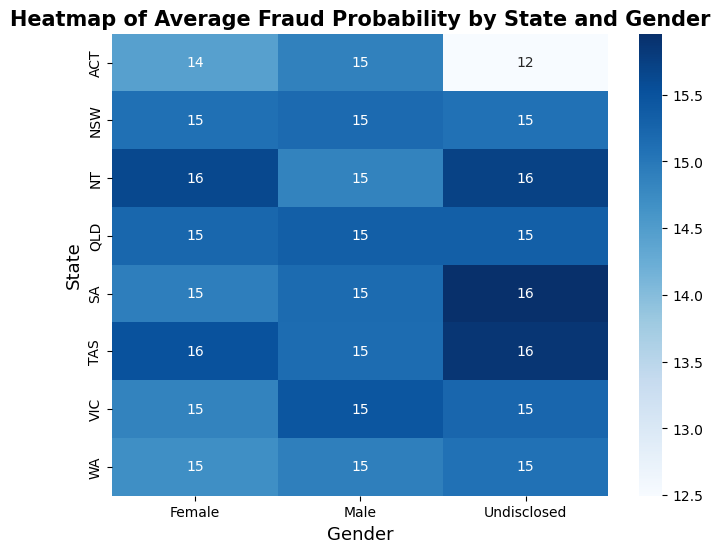

In [9]:
# create a matrix for the heatmap
pivot_table = consumer_pd.pivot_table(values='fraud_probability', index='state', columns='gender', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues')
plt.title('Heatmap of Average Fraud Probability by State and Gender', 
          fontsize=15, weight='bold')
plt.xlabel('Gender', fontsize=13)
plt.ylabel('State', fontsize=13)

# save and display the plot
plt.savefig('../plots/heatmap_avg_fraud_prob_by_state_gender_before.png', dpi=300, bbox_inches='tight')
plt.show()

#### Distribution of consumer fraud probability

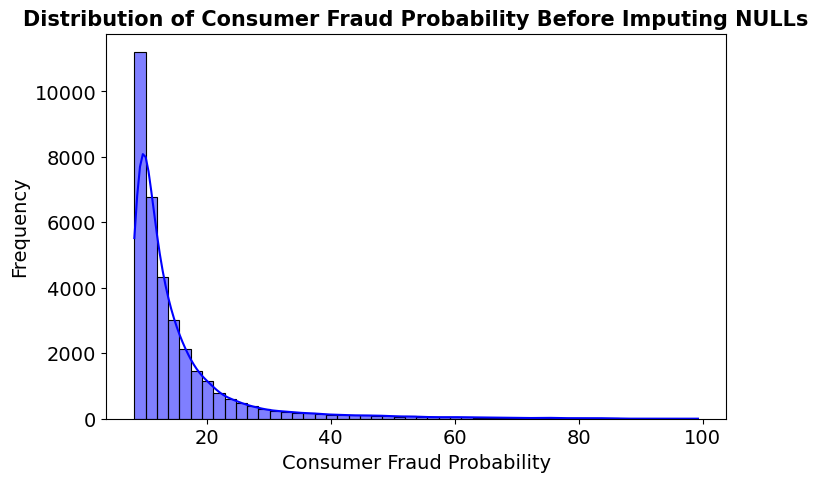

In [ ]:
# plot
plt.figure(figsize=(8, 5))
sns.histplot(consumer_pd['fraud_probability'], kde=True, bins=50, color='blue')
plt.title('Distribution of Consumer Fraud Probability Before Imputing NULLs', 
          fontsize=15, weight='bold',)
plt.xlabel('Consumer Fraud Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.savefig('../plots/consumer_fraud_before.png', dpi=300, bbox_inches='tight')
plt.show()

### AFTER Fill in Missing Values

#### Distribution of consumer fraud probability

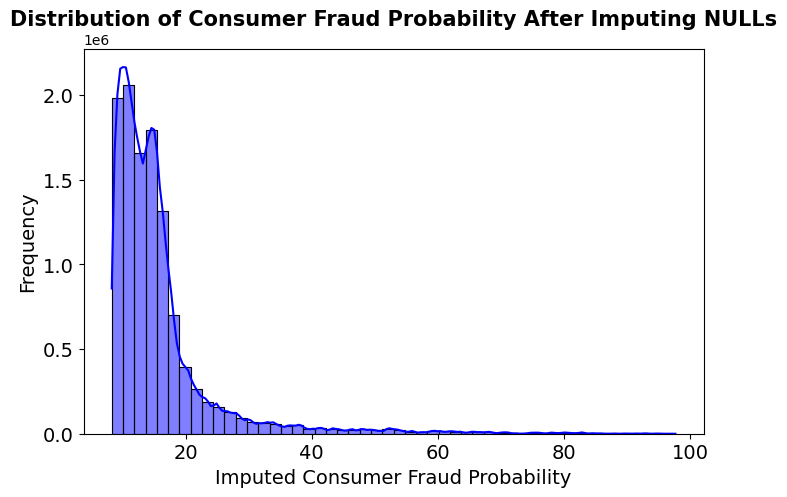

In [5]:
# plot
plt.figure(figsize=(8, 5))
sns.histplot(final_imputed_consumer_df['fraud_probability'], 
             kde=True, bins=50, color='blue')
plt.title('Distribution of Consumer Fraud Probability After Imputing NULLs', 
          fontsize=15, weight='bold',)
plt.xlabel('Imputed Consumer Fraud Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.savefig('../plots/consumer_fraud_after.png', dpi=300, bbox_inches='tight')
plt.show()

# Merchant Related Distributions

### Revenue level distribution

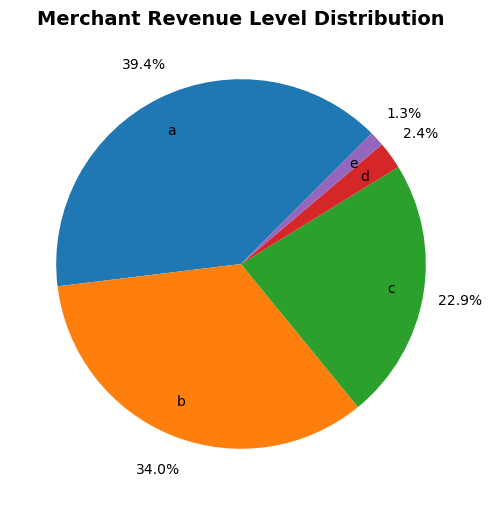

In [52]:
# count the occurrences of each revenue level
revenue_counts = merchant_df['revenue_level'].value_counts()

# plot
plt.figure(figsize=(6,6))
plt.pie(revenue_counts, labels=revenue_counts.index, autopct='%1.1f%%', startangle=45, 
        pctdistance=1.2, labeldistance=0.8)
plt.title('Merchant Revenue Level Distribution', weight='bold', fontsize=14)

# save and display the plot
plt.savefig('../plots/revenue_level_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Take rate distribution

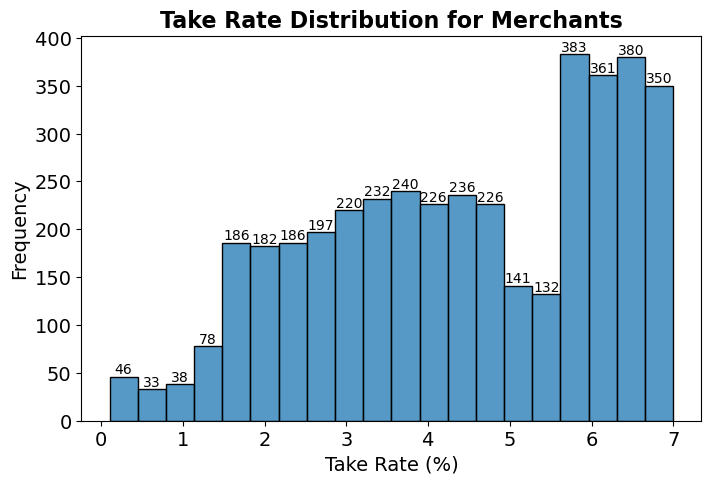

In [24]:
take_rate_data = merchant_df['take_rate']

# plot
plt.figure(figsize=(8, 5))
ax = sns.histplot(take_rate_data, bins=20, kde=False)

plt.title('Take Rate Distribution for Merchants', fontsize=16, weight='bold')
plt.xlabel('Take Rate (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/take_rate_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Total transaction count for each merchant distribution

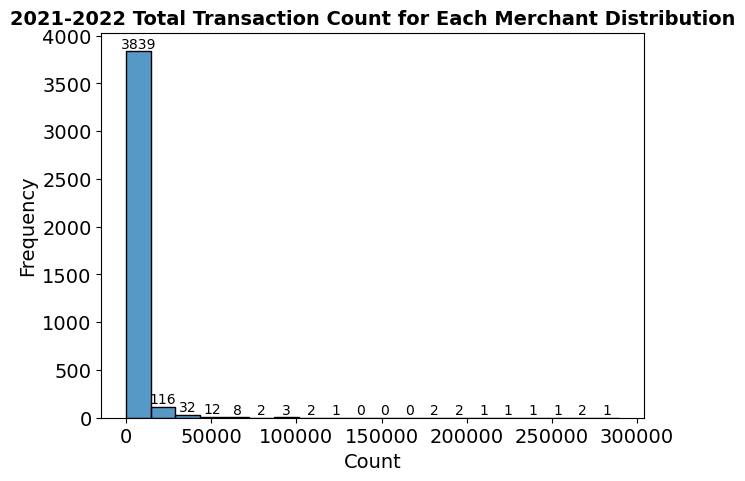

In [7]:
transactions_count_data = merchant_total_count_dollar_df['transaction_count']

# create the plot
plt.figure(figsize=(7, 5))
ax = sns.histplot(transactions_count_data, bins=20, kde=False)

plt.title('2021-2022 Total Transaction Count for Each Merchant Distribution',
          weight='bold', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/merchant_total_count_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Total transaction value for each merchant distribution

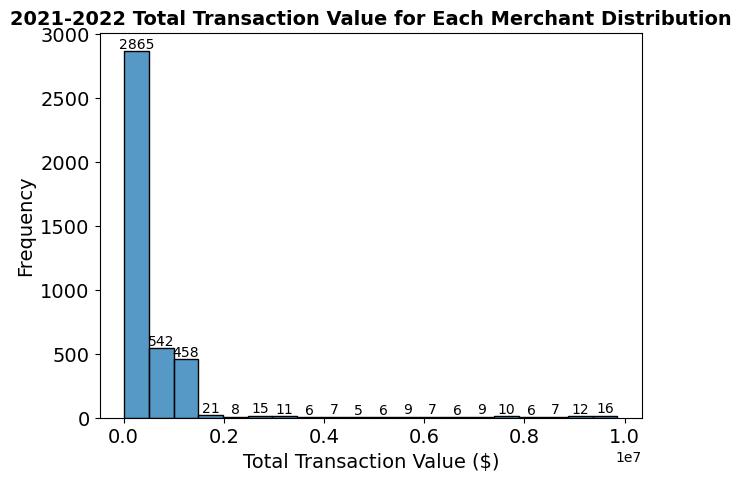

In [ ]:
merchant_total_dollar_data = merchant_total_count_dollar_df['total_dollar_value']

# create the plot
plt.figure(figsize=(7, 5))
ax = sns.histplot(merchant_total_dollar_data, bins=20, kde=False)

plt.title('2021-2022 Total Transaction Value for Each Merchant Distribution', weight='bold', fontsize=14)
plt.xlabel('Total Transaction Value ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/merchant_total_values_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Total transaction revenue for each merchant distribution

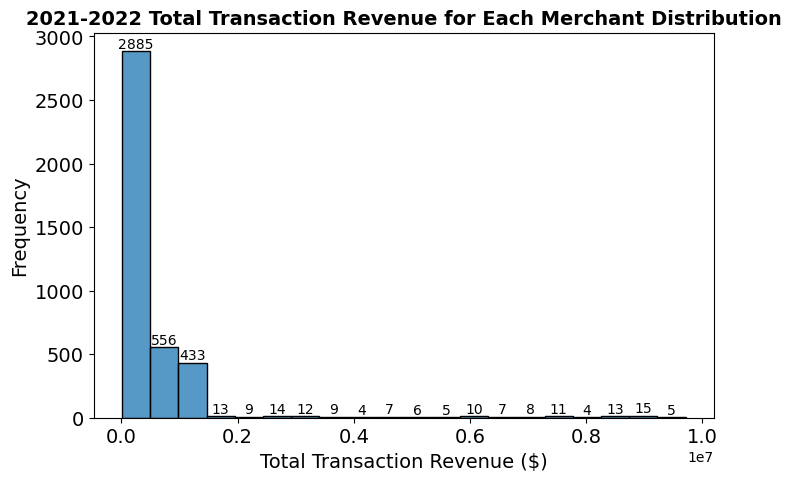

In [23]:
# combine `merchant_abn` to find the total revenue of each abn
merged_df = merchant_select_df.groupby('merchant_abn')['transaction_revenue'].sum().reset_index()
revenue_data = merged_df['transaction_revenue']

# plot
plt.figure(figsize=(8, 5))
ax = sns.histplot(revenue_data, bins=20, kde=False)

plt.title('2021-2022 Total Transaction Revenue for Each Merchant Distribution', 
          fontsize=14, weight='bold')
plt.xlabel('Total Transaction Revenue ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )
    
# save and display the plot
plt.savefig('../plots/merchant_total_revenue_hist.png', dpi=300, bbox_inches='tight')
plt.show()

## Merchant Fraud Probability Distributions

### BEFORE fill in missing values

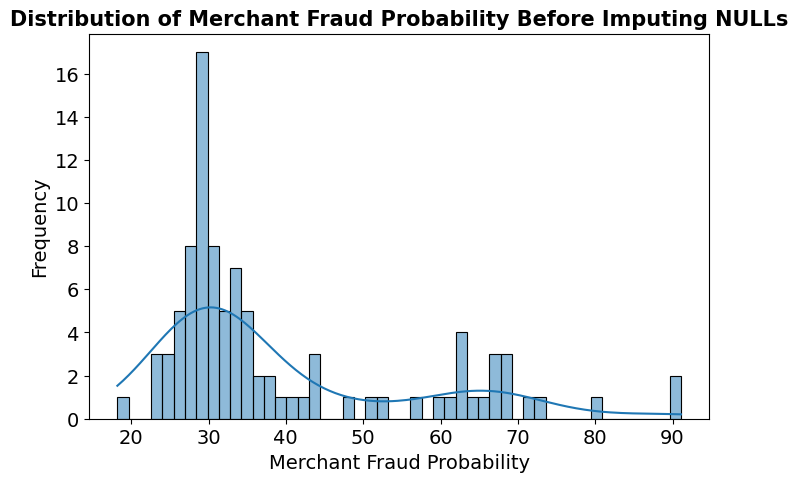

In [4]:
merchant_fraud_not_null_data = merchant_df[merchant_df['fraud_probability'].notnull()]

# plot
plt.figure(figsize=(8, 5))
sns.histplot(merchant_fraud_not_null_data['fraud_probability'], kde=True, bins=50)
plt.title('Distribution of Merchant Fraud Probability Before Imputing NULLs', 
          fontsize=15, weight='bold',)
plt.xlabel('Merchant Fraud Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.savefig('../plots/merchant_fraud_before.png', dpi=300, bbox_inches='tight')
plt.show()

### AFTER fill in missing values

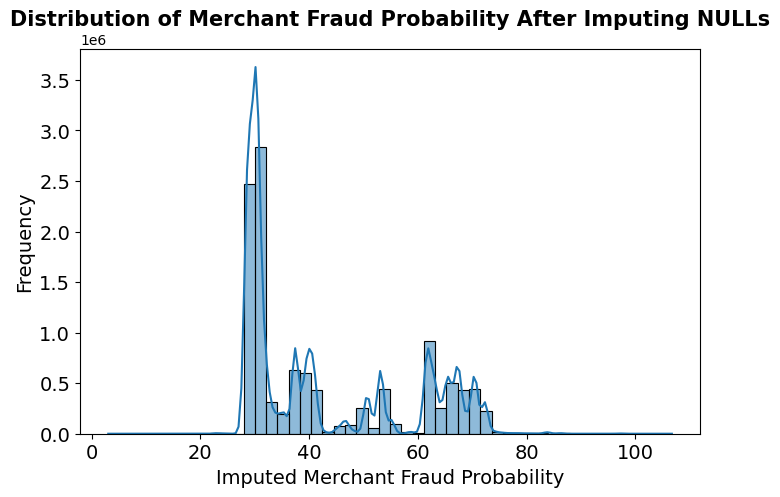

In [9]:
# plot
plt.figure(figsize=(8, 5))

# plot the distribution of the fraud_probability predictions
sns.histplot(final_imputed_merchant_df['fraud_probability'], bins=50, kde=True)

# add labels and title
plt.title('Distribution of Merchant Fraud Probability After Imputing NULLs', 
          fontsize=15, weight='bold',)
plt.xlabel('Imputed Merchant Fraud Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.savefig('../plots/merchant_fraud_after.png', dpi=300, bbox_inches='tight')
plt.show()

# External Data Related distributions

### Population distribution by SA2

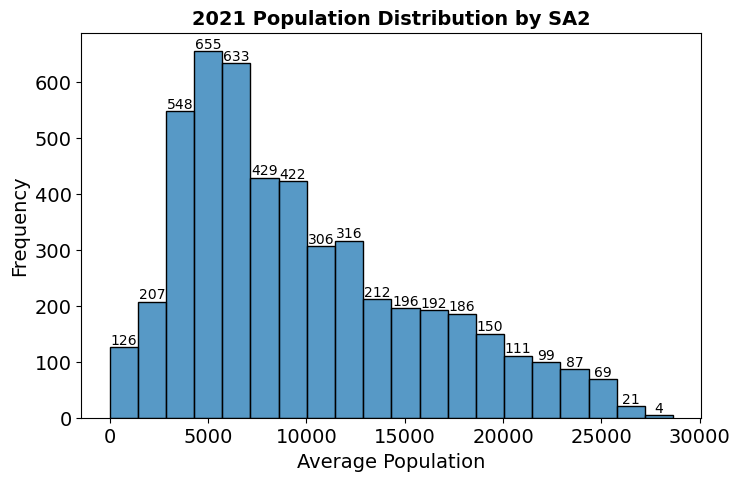

In [10]:
population_data = merged_external_df['average_population']

# create the plot
plt.figure(figsize=(8, 5))
ax = sns.histplot(population_data, bins=20, kde=False)

plt.title('2021 Population Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Average Population', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/population_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Age distribution by SA2

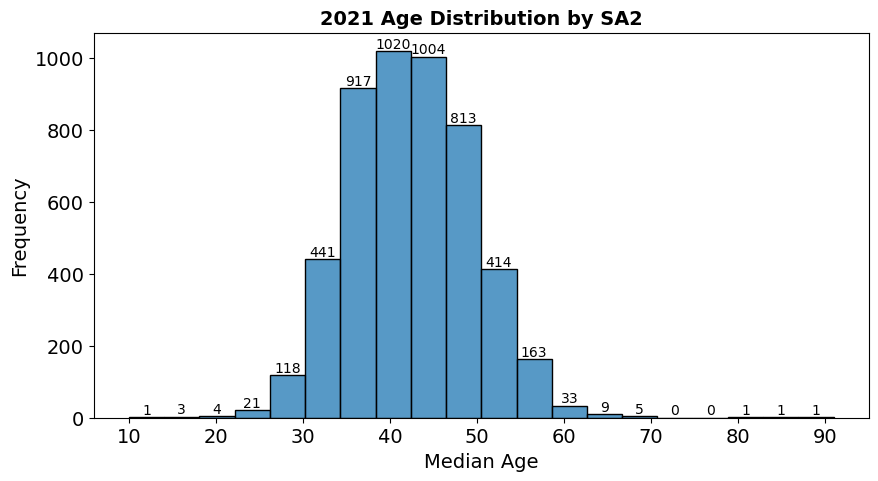

In [11]:
age_data = merged_external_df['Median_age_persons']

# create the plot
plt.figure(figsize=(10, 5))
ax = sns.histplot(age_data, bins=20, kde=False)

plt.title('2021 Age Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Median Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/age_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Monthly mortgage repayment distribution by SA2

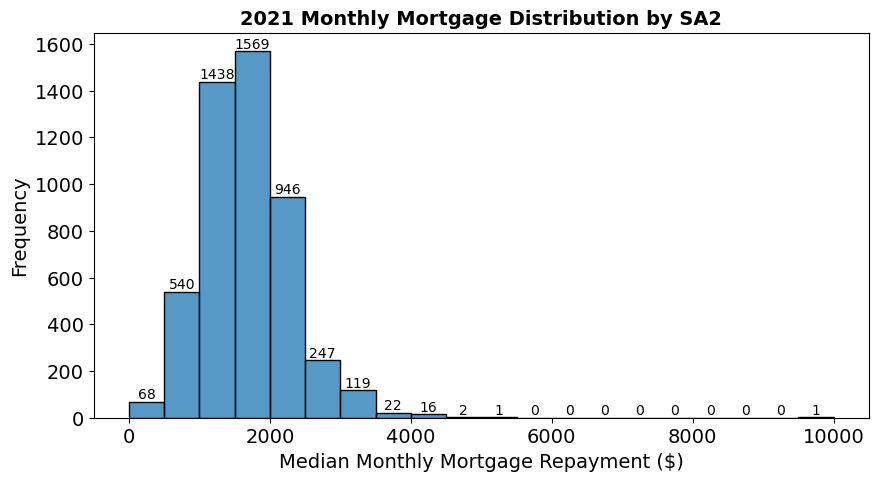

In [12]:
mortgage_data = merged_external_df['Median_mortgage_repay_monthly']

# create the plot
plt.figure(figsize=(10, 5))
ax = sns.histplot(mortgage_data, bins=20, kde=False)

plt.title('2021 Monthly Mortgage Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Median Monthly Mortgage Repayment ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/mortgage_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Total personal weekly income distribution by SA2

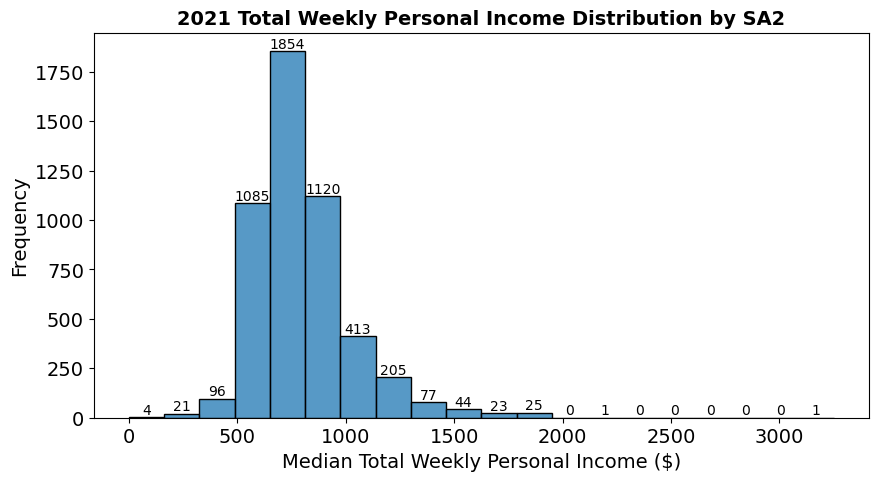

In [13]:
personal_income_data = merged_external_df['Median_tot_prsnl_inc_weekly']

# create the plot
plt.figure(figsize=(10, 5))
ax = sns.histplot(personal_income_data, bins=20, kde=False)

plt.title('2021 Total Weekly Personal Income Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Median Total Weekly Personal Income ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/personal_income_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Weekly rent distribution by SA2

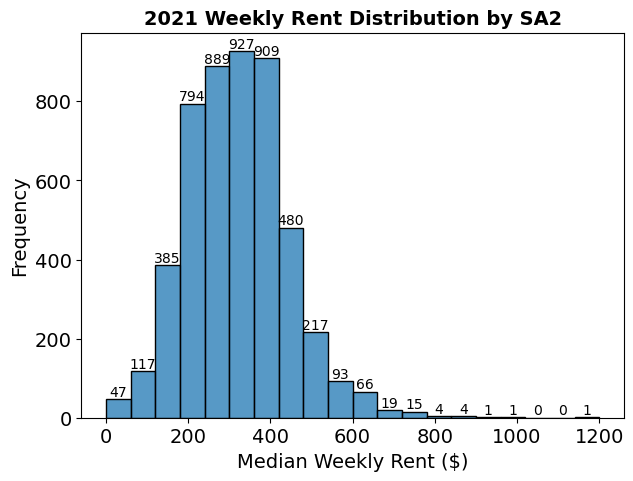

In [14]:
rent_data = merged_external_df['Median_rent_weekly']

# create the plot
plt.figure(figsize=(7, 5))
ax = sns.histplot(rent_data, bins=20, kde=False)

plt.title('2021 Weekly Rent Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Median Weekly Rent ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/rent_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Total family weekly income by SA2

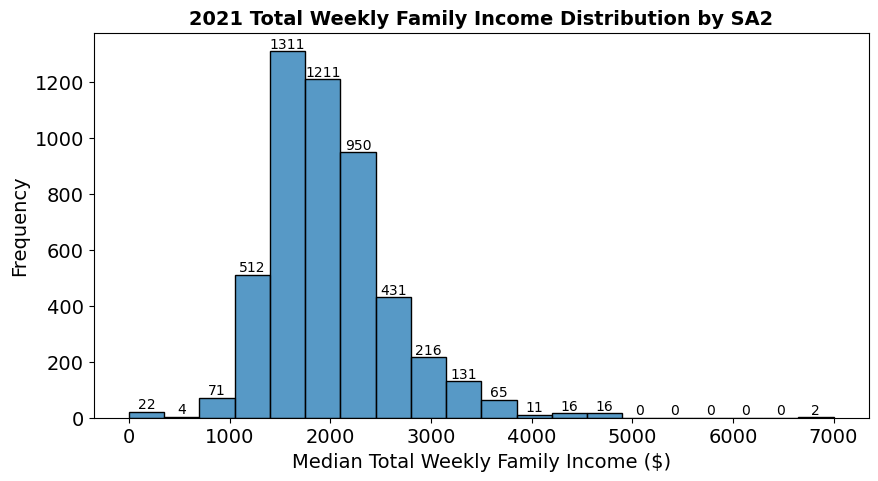

In [15]:
family_income_data = merged_external_df['Median_tot_fam_inc_weekly']

# create the plot
plt.figure(figsize=(10, 5))
ax = sns.histplot(family_income_data, bins=20, kde=False)

plt.title('2021 Total Weekly Family Income Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Median Total Weekly Family Income ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/family_income_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Number of persons per bedroom distribution by SA2

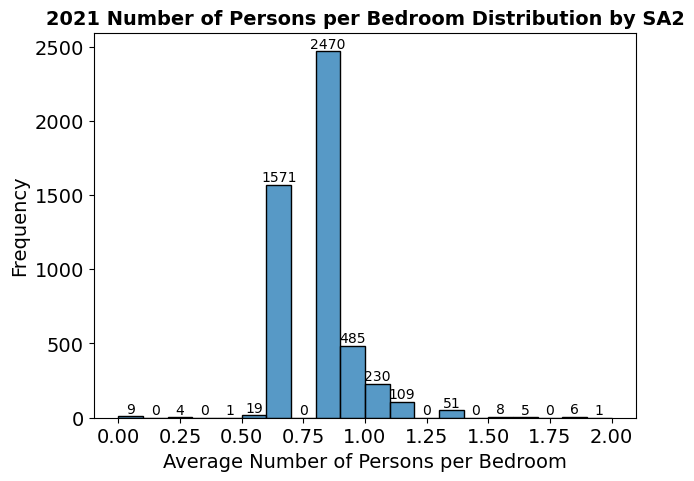

In [16]:
num_psns_per_bedroom_data = merged_external_df['Average_num_psns_per_bedroom']

# create the plot
plt.figure(figsize=(7, 5))
ax = sns.histplot(num_psns_per_bedroom_data, bins=20, kde=False)

plt.title('2021 Number of Persons per Bedroom Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Average Number of Persons per Bedroom', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/num_persons_per_bedroom_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Total household weekly income by SA2

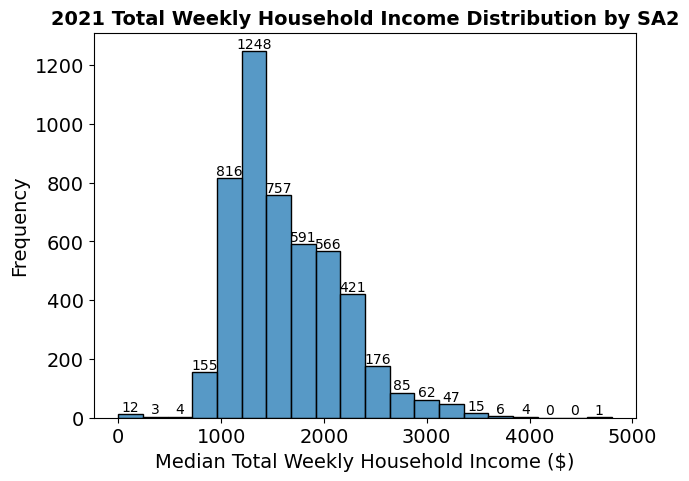

In [17]:
household_income_data = merged_external_df['Median_tot_hhd_inc_weekly']

# create the plot
plt.figure(figsize=(7, 5))
ax = sns.histplot(household_income_data, bins=20, kde=False)

plt.title('2021 Total Weekly Household Income Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Median Total Weekly Household Income ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/household_income_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Household size distribution by SA2

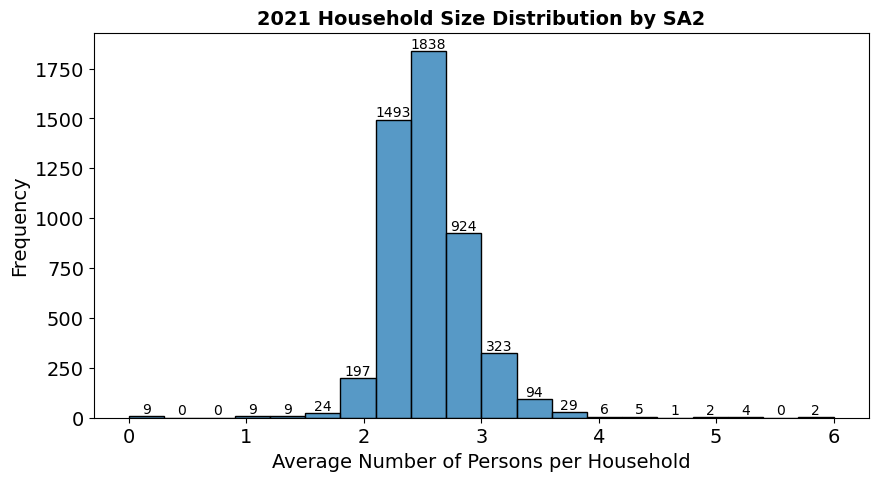

In [18]:
household_size_data = merged_external_df['Average_household_size']

# create the plot
plt.figure(figsize=(10, 5))
ax = sns.histplot(household_size_data, bins=20, kde=False)

plt.title('2021 Household Size Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Average Number of Persons per Household', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/household_size_hist.png', dpi=300, bbox_inches='tight')
plt.show()

### Unemployment rate distribution by SA2

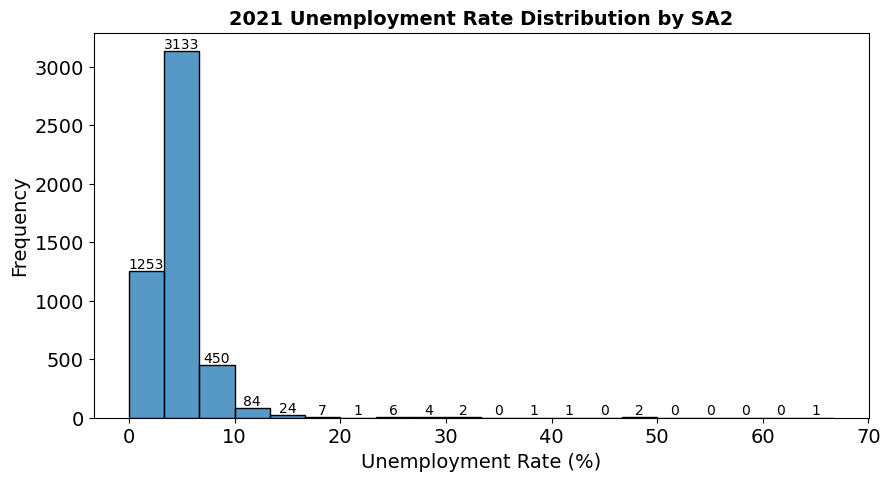

In [19]:
unemp_data = merged_external_df['unemployment_rate']

# create the plot
plt.figure(figsize=(10, 5))
ax = sns.histplot(unemp_data, bins=20, kde=False)

plt.title('2021 Unemployment Rate Distribution by SA2', weight='bold', fontsize=14)
plt.xlabel('Unemployment Rate (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# add labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# save and display the plot
plt.savefig('../plots/unemployment_rate_hist.png', dpi=300, bbox_inches='tight')
plt.show()

# Top 10

### Top 10 merchants by total transaction count and revenue respectively

In [27]:
# get the top 10 data of `transaction_count` and `transaction_revenue`
top_10_by_revenue = merged_df.nlargest(10, 'transaction_revenue')
top_10_by_transaction_count = merchant_total_count_dollar_df.nlargest(10, 'transaction_count')

In [28]:
top_10_by_revenue

,merchant_abn,transaction_revenue
1368,39649557865,9.712498e+06
792,27093785141,9.487136e+06
1838,50315283629,9.459182e+06
1052,32709545238,9.400899e+06
833,28057731482,9.228719e+06
3881,96680767841,9.227153e+06
984,31334588839,9.224268e+06
3614,90568944804,9.223973e+06
3268,82368304209,9.211942e+06
378,18158387243,9.110650e+06


In [26]:
top_10_by_transaction_count

,merchant_abn,transaction_count,total_dollar_value
3018,24852446429,289513,8.698780e+06
1729,86578477987,272674,9.539823e+06
2210,64203420245,260780,7.549445e+06
184,49891706470,247526,7.171594e+06
2079,46804135891,234434,7.042650e+06
1335,45629217853,228255,8.395062e+06
320,89726005175,215963,8.908823e+06
621,43186523025,200913,9.041988e+06
1785,80324045558,196840,7.219970e+06
1750,63290521567,181876,4.402171e+06


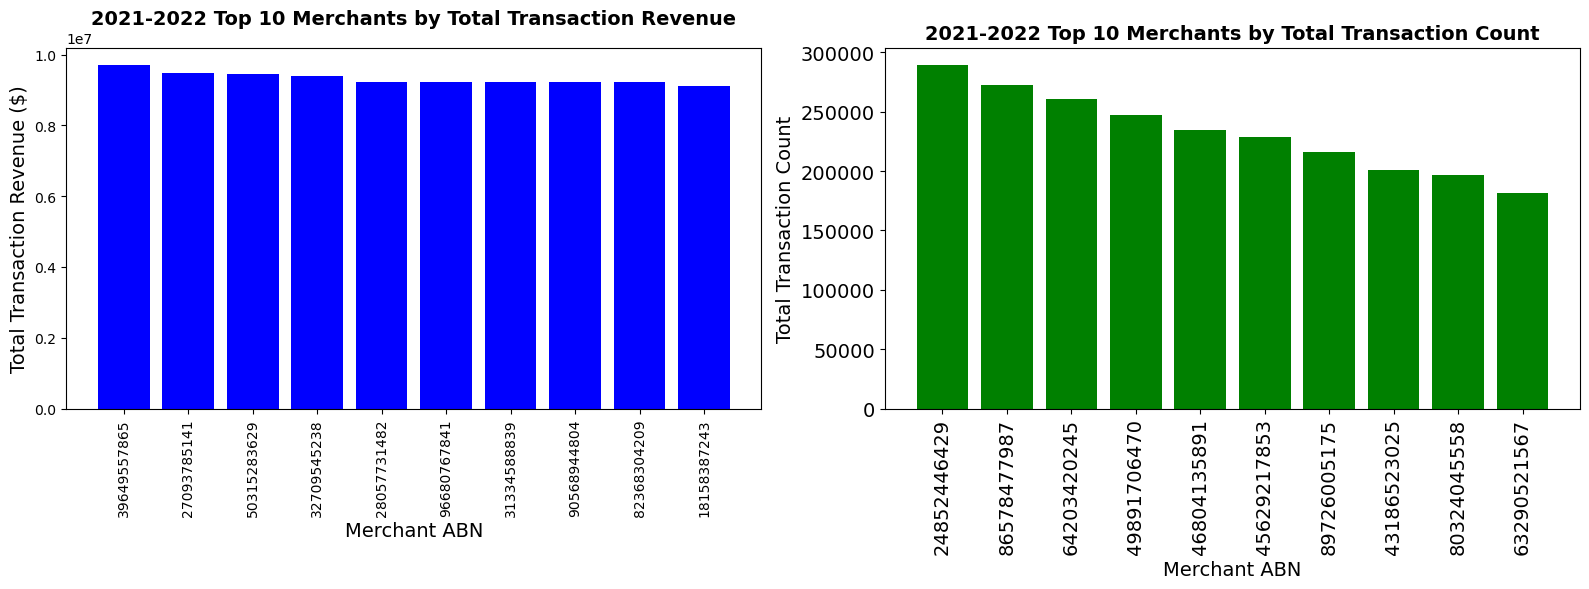

In [30]:
# create the plot with two sub-plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# plot a bar chart of `transaction_revenue`
ax1.bar(top_10_by_revenue['merchant_abn'].astype(str), 
        top_10_by_revenue['transaction_revenue'], color='blue')
ax1.set_title('2021-2022 Top 10 Merchants by Total Transaction Revenue', 
              weight='bold', fontsize=14)
ax1.set_xlabel('Merchant ABN', fontsize=14)
ax1.set_ylabel('Total Transaction Revenue ($)', fontsize=14)
ax1.tick_params(axis='x', rotation=90)

# plot a bar chart of `transaction_count`
ax2.bar(top_10_by_transaction_count['merchant_abn'].astype(str), 
        top_10_by_transaction_count['transaction_count'], color='green')
ax2.set_title('2021-2022 Top 10 Merchants by Total Transaction Count', 
              weight='bold', fontsize=14)
ax2.set_xlabel('Merchant ABN', fontsize=14)
ax2.set_ylabel('Total Transaction Count', fontsize=14)
ax2.tick_params(axis='x', rotation=90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.tight_layout()
plt.savefig('../plots/top10_merchants_toal_transaction_count_revenue.png', 
            dpi=300, bbox_inches='tight')
plt.show()


### Top 10 merchants by total transaction values

In [35]:
top_10_by_dollar_value = merchant_total_count_dollar_df.nlargest(10, 'total_dollar_value')
top_10_by_dollar_value

,merchant_abn,transaction_count,total_dollar_value
1068,39649557865,21919,9.857402e+06
734,96680767841,31134,9.806731e+06
169,27093785141,25928,9.753404e+06
1230,82368304209,5193,9.753248e+06
1582,79827781481,4798,9.734168e+06
1826,32709545238,12912,9.695647e+06
3524,31334588839,1527,9.630683e+06
2802,50315283629,29847,9.628646e+06
39,90568944804,10732,9.618325e+06
1,38700038932,7132,9.546185e+06


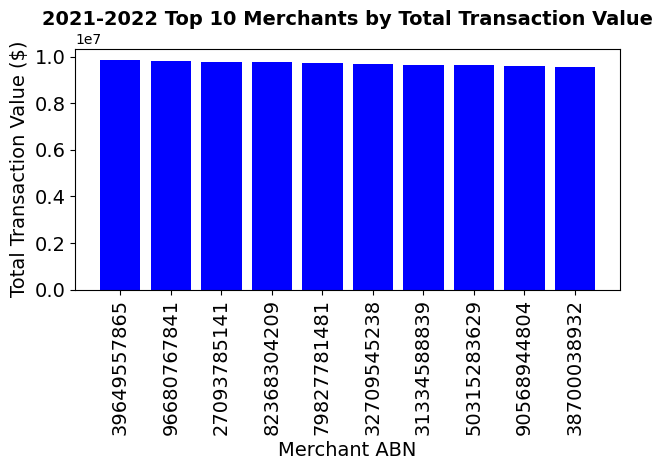

In [34]:
# plot
plt.bar(top_10_by_dollar_value['merchant_abn'].astype(str), 
        top_10_by_dollar_value['total_dollar_value'], color='blue')
plt.title('2021-2022 Top 10 Merchants by Total Transaction Value', 
              weight='bold', fontsize=14)
plt.xlabel('Merchant ABN', fontsize=14)
plt.ylabel('Total Transaction Value ($)', fontsize=14)
plt.tick_params(axis='x', rotation=90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.tight_layout()
plt.savefig('../plots/top10_merchants_toal_transaction_dollar.png', 
            dpi=300, bbox_inches='tight')
plt.show()

### Top 10 consumers by total transaction count and values respectively

In [28]:
# get the top 10 data of `transaction_count` and `total_dollar_value`
top_10_by_dollar_value = consumer_total_count_dollar_df.nlargest(10, 'total_dollar_value')
top_10_by_transaction_count = consumer_total_count_dollar_df.nlargest(10, 'total_transaction_count')

In [29]:
top_10_by_dollar_value

,consumer_id,total_transaction_count,total_dollar_value,user_id,postcode
19598,27622,589,197058.079501,3101,6484
4554,1066024,576,170046.440136,22497,2747
10351,165107,572,164393.813538,11702,7466
6743,65847,569,163990.090534,8117,6487
8552,672669,567,161233.751054,12899,1630
626,658082,565,159338.947712,3489,3082
15697,165620,583,159241.065948,8333,3542
4023,244869,566,159052.169477,7047,7466
23652,826806,553,157381.019206,2376,5172
19967,768908,581,154302.145212,7402,7300


In [30]:
top_10_by_transaction_count

,consumer_id,total_transaction_count,total_dollar_value,user_id,postcode
12990,1355305,604,102848.891831,15998,4520
13637,1074875,603,79419.782002,8475,2399
7399,1258676,602,87985.923828,1000,2285
22729,30862,602,90470.543886,12325,6107
1678,369772,601,96627.898736,14125,7213
2365,1179138,601,84964.403347,7535,3662
2816,693679,601,88605.638038,13850,4356
4415,37238,601,90358.507226,8664,2794
10419,108767,601,95453.692004,20259,2877
10996,1277199,601,84532.447561,7775,2132


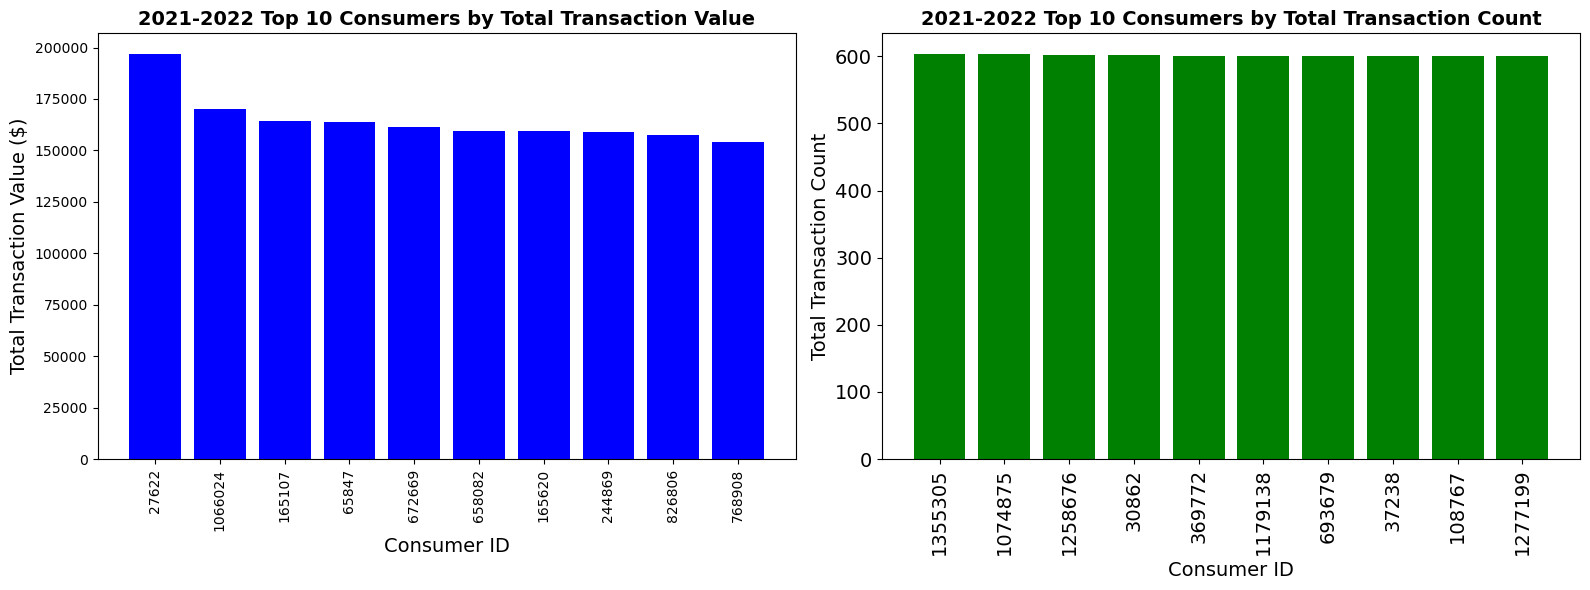

In [31]:
# create the plot with two sub-plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# plot a bar chart of `total_dollar_value`
ax1.bar(top_10_by_dollar_value['consumer_id'].astype(str), 
        top_10_by_dollar_value['total_dollar_value'], color='blue')
ax1.set_title('2021-2022 Top 10 Consumers by Total Transaction Value', weight='bold', fontsize=14)
ax1.set_xlabel('Consumer ID', fontsize=14)
ax1.set_ylabel('Total Transaction Value ($)', fontsize=14)
ax1.tick_params(axis='x', rotation=90)

# plot a bar chart of `total_transaction_count`
ax2.bar(top_10_by_transaction_count['consumer_id'].astype(str), 
        top_10_by_transaction_count['total_transaction_count'], color='green')
ax2.set_title('2021-2022 Top 10 Consumers by Total Transaction Count', weight='bold', fontsize=14)
ax2.set_xlabel('Consumer ID', fontsize=14)
ax2.set_ylabel('Total Transaction Count', fontsize=14)
ax2.tick_params(axis='x', rotation=90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.tight_layout()
plt.savefig('../plots/top10_consumers_toal_transaction_count_dollar.png', 
            dpi=300, bbox_inches='tight')
plt.show()


### Top 10 SA2 by total dollar value for consumers

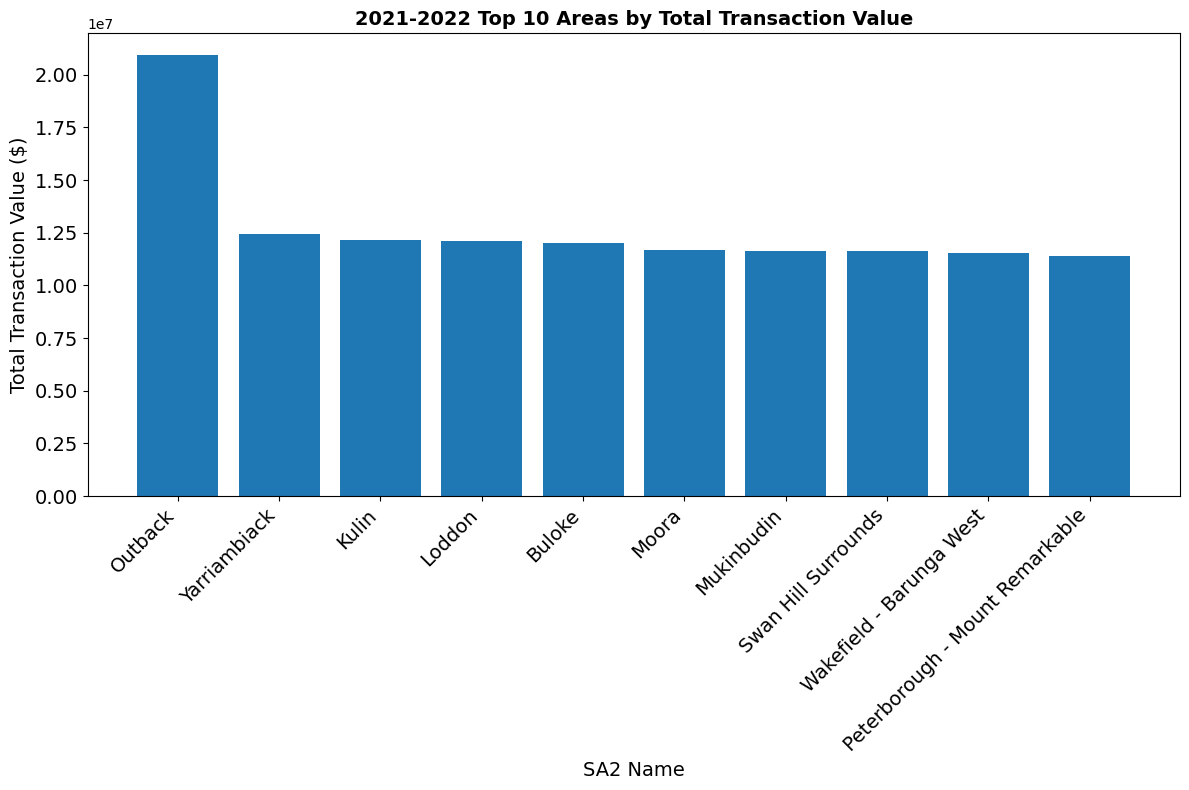

In [32]:
# get the top 10 `dollar_value` data
top_10_dollar_values = consumer_total_count_dollar_bySA2_gdf.nlargest(10, 'total_dollar_value')

# create a plot
plt.figure(figsize=(12, 8))
plt.bar(top_10_dollar_values['SA2_name'], top_10_dollar_values['total_dollar_value'])

plt.title('2021-2022 Top 10 Areas by Total Transaction Value', weight='bold', fontsize=14)
plt.xlabel('SA2 Name', fontsize=14)
plt.ylabel('Total Transaction Value ($)', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# save and display the plot
plt.tight_layout()
plt.savefig('../plots/top10_SA2_by_consumer_dollar.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
top_10_dollar_values

,SA2_name,total_transaction_count,total_dollar_value,postcode,state,geometry
1580,Outback,132369,2.091986e+07,5713,SA,"POLYGON ((133.8416 -28.74865, 133.8354 -28.074..."
2294,Yarriambiack,78918,1.241866e+07,3491,VIC,"POLYGON ((142.239 -35.99787, 142.23898 -35.997..."
1129,Kulin,75917,1.216535e+07,6359,WA,"POLYGON ((117.63905 -32.58162, 117.63989 -32.5..."
1203,Loddon,76694,1.210217e+07,3537,VIC,"POLYGON ((143.4439 -36.42231, 143.44146 -36.42..."
311,Buloke,75560,1.199642e+07,3533,VIC,"POLYGON ((142.53562 -35.34478, 142.53555 -35.3..."
1368,Moora,73046,1.169385e+07,6613,WA,"POLYGON ((115.87617 -30.30305, 115.87626 -30.2..."
1430,Mukinbudin,70718,1.164361e+07,6427,WA,"POLYGON ((117.60365 -30.51835, 117.60365 -30.5..."
1965,Swan Hill Surrounds,73852,1.164101e+07,3584,VIC,"POLYGON ((142.74297 -35.11502, 142.74233 -35.1..."
2119,Wakefield - Barunga West,73971,1.152422e+07,5560,SA,"POLYGON ((137.93754 -33.55275, 137.93938 -33.5..."
1645,Peterborough - Mount Remarkable,71703,1.138977e+07,5433,SA,"POLYGON ((137.91178 -32.84878, 137.91185 -32.8..."


# Maps

In [34]:
geoJSON = merged_external_gdf[['SA2_name', 'geometry']].drop_duplicates('SA2_name').to_json()

### Population distribution by SA2

In [35]:
# select the top 5 SA2 name based on average population
top5_population = merged_external_gdf.nlargest(5, 'average_population')
top5_population

,SA2_name,average_population,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,geometry,postcode,state,unemployment_rate
2056,Tarneit - Central,28645.5,30,1900,830,380,2127,0.9,2164,3.5,"POLYGON ((144.65232 -37.83945, 144.65237 -37.8...",3029,VIC,7.2
841,Schofields - East,27520.5,31,2817,1166,550,2793,0.9,2682,3.2,"POLYGON ((150.87205 -33.6896, 150.87232 -33.68...",2762,NSW,4.7
4220,Baldivis - South,27385.5,32,1915,938,370,2337,0.8,2161,3.0,"POLYGON ((115.79037 -32.3306, 115.79105 -32.32...",6171,WA,5.0
1947,Pakenham - South West,27302.5,33,1800,788,369,1959,0.8,1803,3.0,"POLYGON ((145.43721 -38.0642, 145.43739 -38.06...",3810,VIC,5.2
1612,Wonthaggi - Inverloch,27137.0,51,1467,618,298,1480,0.7,1154,2.2,"POLYGON ((145.4229 -38.41215, 145.42268 -38.41...",3925,VIC,4.0


In [36]:
# create the map
population_map = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=merged_external_gdf[['SA2_name', 'average_population', 'geometry']],
    columns=['SA2_name', 'average_population'],
    key_on='feature.properties.SA2_name',
    bins=7,
    fill_color='RdPu',
    nan_fill_color='gray',
    legend_name='2021 Average Population Distribution by SA2'
).add_to(population_map)

# mark the area of top 5 population
top5_population['centroid'] = top5_population['geometry'].centroid

for _, row in top5_population.iterrows():
    lat, lon = row['centroid'].y, row['centroid'].x
    
    folium.Marker(
        location=[lat, lon],
        popup=f"{row['SA2_name']} Population: {row['average_population']}",
    ).add_to(population_map)

# save the map
population_map.save('../plots/population_map.html')

/var/folders/hx/0_8y1ngj2zx7c7x2zn44jf1r0000gn/T/ipykernel_32428/141613132.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5_population['centroid'] = top5_population['geometry'].centroid


### Age distribution by SA2

In [37]:
# select the top 5 SA2 name based on average age
top5_age= merged_external_gdf.nlargest(5, 'Median_age_persons')
top5_age

,SA2_name,average_population,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,geometry,postcode,state,unemployment_rate
2890,New Chum,3.0,91,0,225,0,0,0.0,0,0.0,"POLYGON ((152.83272 -27.60208, 152.83416 -27.6...",4303,QLD,0.0
4044,Walyunga National Park,0.0,84,0,450,0,0,1.0,450,1.0,"POLYGON ((116.05628 -31.70816, 116.07026 -31.7...",6084,WA,0.0
4904,Parkes (ACT) - South,4.0,82,0,824,178,0,1.0,1375,2.0,"POLYGON ((149.12554 -35.3008, 149.12598 -35.29...",2600,ACT,0.0
1100,Blue Mountains - South,7.0,70,0,900,150,0,0.7,900,1.0,"POLYGON ((150.17345 -33.81724, 150.1734 -33.81...",2787,NSW,0.0
1101,Blue Mountains - South,7.0,70,0,900,150,0,0.7,900,1.0,"POLYGON ((150.17345 -33.81724, 150.1734 -33.81...",2787,NSW,0.0


In [38]:
# create the map
age_map = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=merged_external_gdf[['SA2_name', 'Median_age_persons', 'geometry']],
    columns=['SA2_name', 'Median_age_persons'],
    key_on='feature.properties.SA2_name',
    bins=9,
    fill_color='RdPu',
    nan_fill_color='gray',
    legend_name='2021 Median Age Distribution by SA2'
).add_to(age_map)

# mark the area of top 5 age
top5_age['centroid'] = top5_age['geometry'].centroid

for _, row in top5_age.iterrows():
    lat, lon = row['centroid'].y, row['centroid'].x
    
    folium.Marker(
        location=[lat, lon],
        popup=f"{row['SA2_name']} Age: {row['Median_age_persons']}",
    ).add_to(age_map)

# save the map
age_map.save('../plots/age_map.html')

/var/folders/hx/0_8y1ngj2zx7c7x2zn44jf1r0000gn/T/ipykernel_32428/3382589043.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5_age['centroid'] = top5_age['geometry'].centroid


### Monthly mortgage repayment distribution by SA2

In [39]:
# select the top 5 SA2 name based on median mortgage repayment
top5_mortgage = merged_external_gdf.nlargest(5, 'Median_mortgage_repay_monthly')
top5_mortgage

,SA2_name,average_population,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,geometry,postcode,state,unemployment_rate
3983,Kings Park (WA),50.0,61,9999,2150,1000,4874,0.8,4799,2.2,"POLYGON ((115.83968 -31.96616, 115.83964 -31.9...",6005,WA,0.0
2580,Wooroonooran,3.0,60,5200,1125,0,2250,0.5,2250,1.5,"POLYGON ((145.79548 -17.30782, 145.79553 -17.3...",4860,QLD,0.0
2967,Eungella Hinterland,9.0,61,4800,1625,430,3250,0.7,2624,1.8,"POLYGON ((148.44802 -21.28473, 148.44622 -21.2...",4741,QLD,0.0
2968,Eungella Hinterland,9.0,61,4800,1625,430,3250,0.7,2624,1.8,"POLYGON ((148.44802 -21.28473, 148.44622 -21.2...",4757,QLD,0.0
987,Castle Cove - Northbridge,13403.0,45,4333,1355,850,4641,0.8,3987,2.9,"POLYGON ((151.21145 -33.80199, 151.21134 -33.8...",2063,NSW,3.9


In [40]:
# create the map
mortgage_map = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=merged_external_gdf[['SA2_name', 'Median_mortgage_repay_monthly', 'geometry']],
    columns=['SA2_name', 'Median_mortgage_repay_monthly'],
    key_on='feature.properties.SA2_name',
    bins=9,
    fill_color='RdPu',
    nan_fill_color='gray',
    legend_name='2021 Median Monthly Mortgage Repayment Distribution by SA2'
).add_to(mortgage_map)

# mark the area of top 5 mortgage
top5_mortgage['centroid'] = top5_mortgage['geometry'].centroid

for _, row in top5_mortgage.iterrows():
    lat, lon = row['centroid'].y, row['centroid'].x
    
    folium.Marker(
        location=[lat, lon],
        popup=f"{row['SA2_name']} Mortgage: {row['Median_mortgage_repay_monthly']}",
    ).add_to(mortgage_map)

# save the map
mortgage_map.save('../plots/mortgage_map.html')

/var/folders/hx/0_8y1ngj2zx7c7x2zn44jf1r0000gn/T/ipykernel_32428/2386530670.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5_mortgage['centroid'] = top5_mortgage['geometry'].centroid


### Total personal weekly income distribution by SA2

In [41]:
# select the top 5 SA2 name based on median mortgage repayment
top5_personal_income = merged_external_gdf.nlargest(5, 'Median_tot_prsnl_inc_weekly')
top5_personal_income

,SA2_name,average_population,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,geometry,postcode,state,unemployment_rate
3576,Adelaide Airport,3.0,51,0,3250,0,0,0.0,0,0.0,"POLYGON ((138.5475 -34.93819, 138.54757 -34.93...",5950,SA,0.0
3983,Kings Park (WA),50.0,61,9999,2150,1000,4874,0.8,4799,2.2,"POLYGON ((115.83968 -31.96616, 115.83964 -31.9...",6005,WA,0.0
4420,Ashburton (WA),7807.5,34,1613,1865,48,3310,0.9,2937,2.7,"MULTIPOLYGON (((115.33915 -20.96123, 115.33913...",6710,WA,2.0
4421,Ashburton (WA),7807.5,34,1613,1865,48,3310,0.9,2937,2.7,"MULTIPOLYGON (((115.33915 -20.96123, 115.33913...",6711,WA,2.0
4422,Ashburton (WA),7807.5,34,1613,1865,48,3310,0.9,2937,2.7,"MULTIPOLYGON (((115.33915 -20.96123, 115.33913...",6712,WA,2.0


In [42]:
# create the map
personal_income_map = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=merged_external_gdf[['SA2_name', 'Median_tot_prsnl_inc_weekly', 'geometry']],
    columns=['SA2_name', 'Median_tot_prsnl_inc_weekly'],
    key_on='feature.properties.SA2_name',
    bins=9,
    fill_color='RdPu',
    nan_fill_color='gray',
    legend_name='2021 Median Total Weekly Personal Income Distribution by SA2'
).add_to(personal_income_map)

# mark the area of top 5 weekly personal income
top5_personal_income['centroid'] = top5_personal_income['geometry'].centroid

for _, row in top5_personal_income.iterrows():
    lat, lon = row['centroid'].y, row['centroid'].x
    
    folium.Marker(
        location=[lat, lon],
        popup=f"{row['SA2_name']} Total Weekly Personal Income: {row['Median_tot_prsnl_inc_weekly']}",
    ).add_to(personal_income_map)

# save the map
personal_income_map.save('../plots/personal_income_map.html')

/var/folders/hx/0_8y1ngj2zx7c7x2zn44jf1r0000gn/T/ipykernel_32428/1105636940.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5_personal_income['centroid'] = top5_personal_income['geometry'].centroid


### Total weekly household income distribution by SA2

In [43]:
# select the top 5 SA2 name based on weekly total personal income
top5_household_income = merged_external_gdf.nlargest(5, 'Median_tot_hhd_inc_weekly')
top5_household_income

,SA2_name,average_population,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,geometry,postcode,state,unemployment_rate
3983,Kings Park (WA),50.0,61,9999,2150,1000,4874,0.8,4799,2.2,"POLYGON ((115.83968 -31.96616, 115.83964 -31.9...",6005,WA,0.0
987,Castle Cove - Northbridge,13403.0,45,4333,1355,850,4641,0.8,3987,2.9,"POLYGON ((151.21145 -33.80199, 151.21134 -33.8...",2063,NSW,3.9
988,Castle Cove - Northbridge,13403.0,45,4333,1355,850,4641,0.8,3987,2.9,"POLYGON ((151.21145 -33.80199, 151.21134 -33.8...",2068,NSW,3.9
989,Castle Cove - Northbridge,13403.0,45,4333,1355,850,4641,0.8,3987,2.9,"POLYGON ((151.21145 -33.80199, 151.21134 -33.8...",2069,NSW,3.9
4905,Red Hill (ACT),3173.5,42,3500,1469,500,4667,0.8,3938,2.8,"POLYGON ((149.1161 -35.33688, 149.11656 -35.33...",2603,ACT,3.4


In [44]:
# create the map
household_income_map = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=merged_external_gdf[['SA2_name', 'Median_tot_hhd_inc_weekly', 'geometry']],
    columns=['SA2_name', 'Median_tot_hhd_inc_weekly'],
    key_on='feature.properties.SA2_name',
    bins=9,
    fill_color='RdPu',
    nan_fill_color='gray',
    legend_name='2021 Median Total Weekly Household Income Distribution by SA2'
).add_to(household_income_map)

# mark the area of top 5 weekly household income
top5_household_income['centroid'] = top5_household_income['geometry'].centroid

for _, row in top5_household_income.iterrows():
    lat, lon = row['centroid'].y, row['centroid'].x
    
    folium.Marker(
        location=[lat, lon],
        popup=f"{row['SA2_name']} Total Weekly Household Income: {row['Median_tot_hhd_inc_weekly']}",
    ).add_to(household_income_map)

# save the map
household_income_map.save('../plots/household_income_map.html')

/var/folders/hx/0_8y1ngj2zx7c7x2zn44jf1r0000gn/T/ipykernel_32428/3419603194.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5_household_income['centroid'] = top5_household_income['geometry'].centroid


### Weekly rent distribution by SA2

In [45]:
# select the top 5 SA2 name based on weekly rent
top5_rent = merged_external_gdf.nlargest(5, 'Median_rent_weekly')
top5_rent

,SA2_name,average_population,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,geometry,postcode,state,unemployment_rate
858,Port Botany Industrial,9.0,61,3179,1812,1200,3749,0.9,2499,1.8,"POLYGON ((151.22091 -33.96895, 151.22066 -33.9...",2036,NSW,0.0
3983,Kings Park (WA),50.0,61,9999,2150,1000,4874,0.8,4799,2.2,"POLYGON ((115.83968 -31.96616, 115.83964 -31.9...",6005,WA,0.0
4109,Ashendon - Lesley,3.0,46,0,0,927,0,0.2,0,1.0,"POLYGON ((116.15935 -32.13593, 116.1593 -32.12...",6111,WA,0.0
1047,Belrose,8652.5,46,3464,903,885,3121,0.8,2601,2.9,"POLYGON ((151.19192 -33.73102, 151.19065 -33.7...",2085,NSW,2.9
987,Castle Cove - Northbridge,13403.0,45,4333,1355,850,4641,0.8,3987,2.9,"POLYGON ((151.21145 -33.80199, 151.21134 -33.8...",2063,NSW,3.9


In [46]:
# create the map
rent_map = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=merged_external_gdf[['SA2_name', 'Median_rent_weekly', 'geometry']],
    columns=['SA2_name', 'Median_rent_weekly'],
    key_on='feature.properties.SA2_name',
    bins=9,
    fill_color='RdPu',
    nan_fill_color='gray',
    legend_name='2021 Median Total Weekly Rent Distribution by SA2'
).add_to(rent_map)

# mark the area of top 5 weekly rent
top5_rent['centroid'] = top5_rent['geometry'].centroid

for _, row in top5_rent.iterrows():
    lat, lon = row['centroid'].y, row['centroid'].x
    
    folium.Marker(
        location=[lat, lon],
        popup=f"{row['SA2_name']} Total Weekly Rent: {row['Median_rent_weekly']}",
    ).add_to(rent_map)

# save the map
rent_map.save('../plots/rent_map.html')

/var/folders/hx/0_8y1ngj2zx7c7x2zn44jf1r0000gn/T/ipykernel_32428/1470056722.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5_rent['centroid'] = top5_rent['geometry'].centroid


### Unemployment rate distribution by SA2

In [47]:
# select the top 5 SA2 name based on unemployment rate
top5_unemp = merged_external_gdf.nlargest(5, 'unemployment_rate')
top5_unemp

,SA2_name,average_population,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,geometry,postcode,state,unemployment_rate
4954,Whitlam,30.5,27,2750,75,0,900,1.5,900,6.0,"POLYGON ((149.05114 -35.26921, 149.05092 -35.2...",2611,ACT,66.7
2887,Carole Park,7.0,36,0,1062,150,2250,0.6,2250,2.0,"POLYGON ((152.91544 -27.61917, 152.91593 -27.6...",4300,QLD,50.0
3443,Parafield,18.0,22,0,274,0,0,0.0,0,0.0,"POLYGON ((138.61917 -34.79599, 138.61976 -34.7...",5106,SA,50.0
3062,Kowanyama - Pormpuraaw,1756.5,30,0,345,118,902,1.3,1104,3.6,"MULTIPOLYGON (((141.591 -15.19652, 141.59143 -...",4892,QLD,42.0
2581,Yarrabah,2608.0,25,1392,337,150,911,1.5,1254,4.5,"MULTIPOLYGON (((145.90107 -16.99399, 145.90083...",4871,QLD,37.2


In [48]:
# create the map
unemp_map = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=merged_external_gdf,
    columns=['SA2_name', 'unemployment_rate'],
    key_on='feature.properties.SA2_name',
    bins=9,
    fill_color='RdPu',
    nan_fill_color='gray',
    legend_name='2021 Unemployment Rate Distribution by SA2'
).add_to(unemp_map)

# mark the area of top 5 unemployment rate
top5_unemp['centroid'] = top5_unemp['geometry'].centroid

for _, row in top5_unemp.iterrows():
    lat, lon = row['centroid'].y, row['centroid'].x
    
    folium.Marker(
        location=[lat, lon],
        popup=f"{row['SA2_name']} Unemployment Rate: {row['unemployment_rate']}",
    ).add_to(unemp_map)

# save the plot
unemp_map.save('../plots/unemployment_rate_map.html')

/var/folders/hx/0_8y1ngj2zx7c7x2zn44jf1r0000gn/T/ipykernel_32428/527060310.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5_unemp['centroid'] = top5_unemp['geometry'].centroid


### Total transaction value distribution for consumers by SA2

In [49]:
# select the top 5 SA2 name based on total transsaction value by consumers
top5_SA2_consumer = consumer_total_count_dollar_bySA2_gdf.nlargest(5, 'total_dollar_value')
top5_SA2_consumer

,SA2_name,total_transaction_count,total_dollar_value,postcode,state,geometry
1580,Outback,132369,2.091986e+07,5713,SA,"POLYGON ((133.8416 -28.74865, 133.8354 -28.074..."
2294,Yarriambiack,78918,1.241866e+07,3491,VIC,"POLYGON ((142.239 -35.99787, 142.23898 -35.997..."
1129,Kulin,75917,1.216535e+07,6359,WA,"POLYGON ((117.63905 -32.58162, 117.63989 -32.5..."
1203,Loddon,76694,1.210217e+07,3537,VIC,"POLYGON ((143.4439 -36.42231, 143.44146 -36.42..."
311,Buloke,75560,1.199642e+07,3533,VIC,"POLYGON ((142.53562 -35.34478, 142.53555 -35.3..."


In [54]:
# create the map
dollar_map = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
    data=consumer_total_count_dollar_bySA2_gdf,
    columns=['SA2_name', 'total_dollar_value'],
    key_on='feature.properties.SA2_name',
    bins=7,
    fill_color='RdPu',
    nan_fill_color='gray',
    legend_name='2021-2022 Total transaction value distribution for consumers by SA2'
).add_to(dollar_map)

# mark the area of top 5 total transsaction value by consumers
top5_SA2_consumer['centroid'] = top5_SA2_consumer['geometry'].centroid

for _, row in top5_SA2_consumer.iterrows():
    lat, lon = row['centroid'].y, row['centroid'].x
    
    folium.Marker(
        location=[lat, lon],
        popup=f"{row['SA2_name']} Total transaction values: {row['total_dollar_value']}",
    ).add_to(dollar_map)

# save the plot
dollar_map.save('../plots/total_dollar_consumers_map.html')

/var/folders/hx/0_8y1ngj2zx7c7x2zn44jf1r0000gn/T/ipykernel_32428/2696905361.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top5_SA2_consumer['centroid'] = top5_SA2_consumer['geometry'].centroid


### Total transaction count distribution for consumers by SA2

In [51]:
# select the top 5 SA2 name based on total transsaction count by consumers
top5_SA2_consumer_count = consumer_total_count_dollar_bySA2_gdf.nlargest(5, 'total_transaction_count')
top5_SA2_consumer_count

,SA2_name,total_transaction_count,total_dollar_value,postcode,state,geometry
1580,Outback,132369,2.091986e+07,5713,SA,"POLYGON ((133.8416 -28.74865, 133.8354 -28.074..."
2294,Yarriambiack,78918,1.241866e+07,3491,VIC,"POLYGON ((142.239 -35.99787, 142.23898 -35.997..."
1203,Loddon,76694,1.210217e+07,3537,VIC,"POLYGON ((143.4439 -36.42231, 143.44146 -36.42..."
1129,Kulin,75917,1.216535e+07,6359,WA,"POLYGON ((117.63905 -32.58162, 117.63989 -32.5..."
311,Buloke,75560,1.199642e+07,3533,VIC,"POLYGON ((142.53562 -35.34478, 142.53555 -35.3..."


Since the top 5 SA2 name based on total transaction count by consumers is the same as the top 5 SA2 name based on total transaction value by consumers and just has different order, we won't plot this map again.